### Test - Propagation Length Analysis - Refractogram

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

In [2]:
import sys
sys.path.insert(0, '/Users/sm13118/Library/CloudStorage/OneDrive-ImperialCollegeLondon/dev/synthPy/')   # import path/to/synthpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches
import numpy as np
import pickle
from scipy import ndimage
import solvers.rtm_solver as rtm
import utils.power_spectrum as util

c1 = '#1C6758'   # dark green
c2 = '#006e23'   # ciano
c3 = '#6e0052'   # violet
c4 = '#db4900'   # purple
c5 = '#37e67d'   # light green

/rds/general/user/le322/home/synthPy/solver/rtm_solver.py:133: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if axis is 'y':


### Import Refractograms

In [4]:
re_01b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/512_0.1_refract.pkl", "rb"))
re_025b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/depth_test/512_0.25_refract.pkl", "rb"))
re_03b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/512_0.3_refract.pkl", "rb"))
re_04b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/512_0.4_refract.pkl", "rb"))
re_050b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/depth_test/512_0.5_refract.pkl", "rb"))
re_075b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/depth_test/512_0.75_refract.pkl", "rb"))
re_100b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/depth_test/512_1.0_refract.pkl", "rb"))
re_125b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/depth_test/512_1.25_refract.pkl", "rb"))
re_150b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/depth_test/512_1.5_refract.pkl", "rb"))
re_175b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/depth_test/512_1.75_refract.pkl", "rb"))
re_200b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/depth_test/512_2.0_refract.pkl", "rb"))
re_300b = pickle.load(open("/rds/general/user/le322/home/synthPy/output/depth_test/512_2.0_refract.pkl", "rb"))

lengths = [1.5, 3.5]
factors = [0.25, 0.3, 0.4, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
extents = np.array(factors)*10

r_15 = []
r_25 = [re_025b, re_03b, re_04b,re_050b , re_075b, re_100b, re_125b, re_150b, re_175b, re_200b]
r_35 = []

for factor in factors:
    factor = str(factor)
    re = pickle.load(open(f"/rds/general/user/le322/home/synthPy/output/length_scale/1.5_0.1/{factor}refract.pkl", "rb"))
    r_15.append(re)
    re = pickle.load(open(f"/rds/general/user/le322/home/synthPy/output/length_scale/3.5_0.1/{factor}refract.pkl", "rb"))
    r_35.append(re)
    plt.imshow(re, clim = (0,10))

FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/user/le322/home/synthPy/output/512_0.1_refract.pkl'

### Supplementary Functions

In [3]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from lmfit.models import GaussianModel, ConstantModel

def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2, 1],[0,-1,-2], shape=(L, L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def clean(sig_corr):
    # baseline          =   baseline_als_optimized(sig, 4e10, 1e-3)
    # sig_corr        =   (sig - baseline ) / baseline
    try:
        sig_norm       =   (sig_corr - sig_corr.min()) / (sig_corr.max() + sig_corr.min())
    except:
        sig_norm = sig_corr
    return sig_norm

def total(arr):
    totals = []
    for i, r1 in enumerate(arr):
        totalSum = np.zeros(r1.shape[0])
        for j in range(len(r1[:,0]) - 1):
            totalSum[j] += np.sum((r1[j,:]))
        totals.append(clean(totalSum))
    print(len(totals))
    return totals

# Fitting gaussian and plot deflection angle distribution
def plot_grams(totals):
    fig, axes = plt.subplots(2,5, figsize = (20,10))
    ax = axes.flatten()
    stds = []
    chis = []
    x = np.linspace(-35,35, len(totals[0]))
    for i, total in enumerate(totals):
        # ax1.plot(x, total1, lw=1.5, alpha = 15 / 15, zorder=2)
        # ax2.plot(x, total2, lw=1.5, alpha = 15 / 15, zorder=2)
        mod               =   GaussianModel() + ConstantModel()
        mod.make_params()
        mod.set_param_hint('sigma', value=20)
        mod.set_param_hint('amplitude', value=1)
        res1 = mod.fit(total, x = x, nan_policy='omit')
        ax[i].plot(x, res1.best_fit, color='red', linewidth=4.0, zorder = 4)
        nstd     = 8 # to draw 5-sigma intervals
        error_up = res1.best_fit + nstd * res1.eval_uncertainty()
        error_dw = res1.best_fit - nstd * res1.eval_uncertainty()
        ax[i].fill_between(x, 
                        error_up,
                        error_dw, 
                        color='red', alpha=1,  edgecolor='b', lw = 0)

        ax[i].fill_between(x, total, facecolor = c4, alpha=0.5, zorder = 2, lw = 0.1)
        sigma1 = res1.best_values['sigma']
        stds.append(sigma1)

    for i, a in enumerate(ax):
    #     a.grid()
        a.set_xlabel(r'Fourier Axis, $\phi$ [mrad]',fontsize = 18)
        a.set_title(f'{extents[i]} mm, , $\sigma$ = {np.round(stds[i],3 )}')
        a.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    return fig, stds

r_15 = total(r_15)
r_25 = total(r_25)
r_35 = total(r_35)

10
10
10


[0.029353371108296722, 2.5327207116217583, 5.112660627970436, 6.367917158844676, 9.24202136391458, 9.889517292845571, 10.653118272842091, 11.049603270642796, 11.961242405512735, 10.793681228768595]


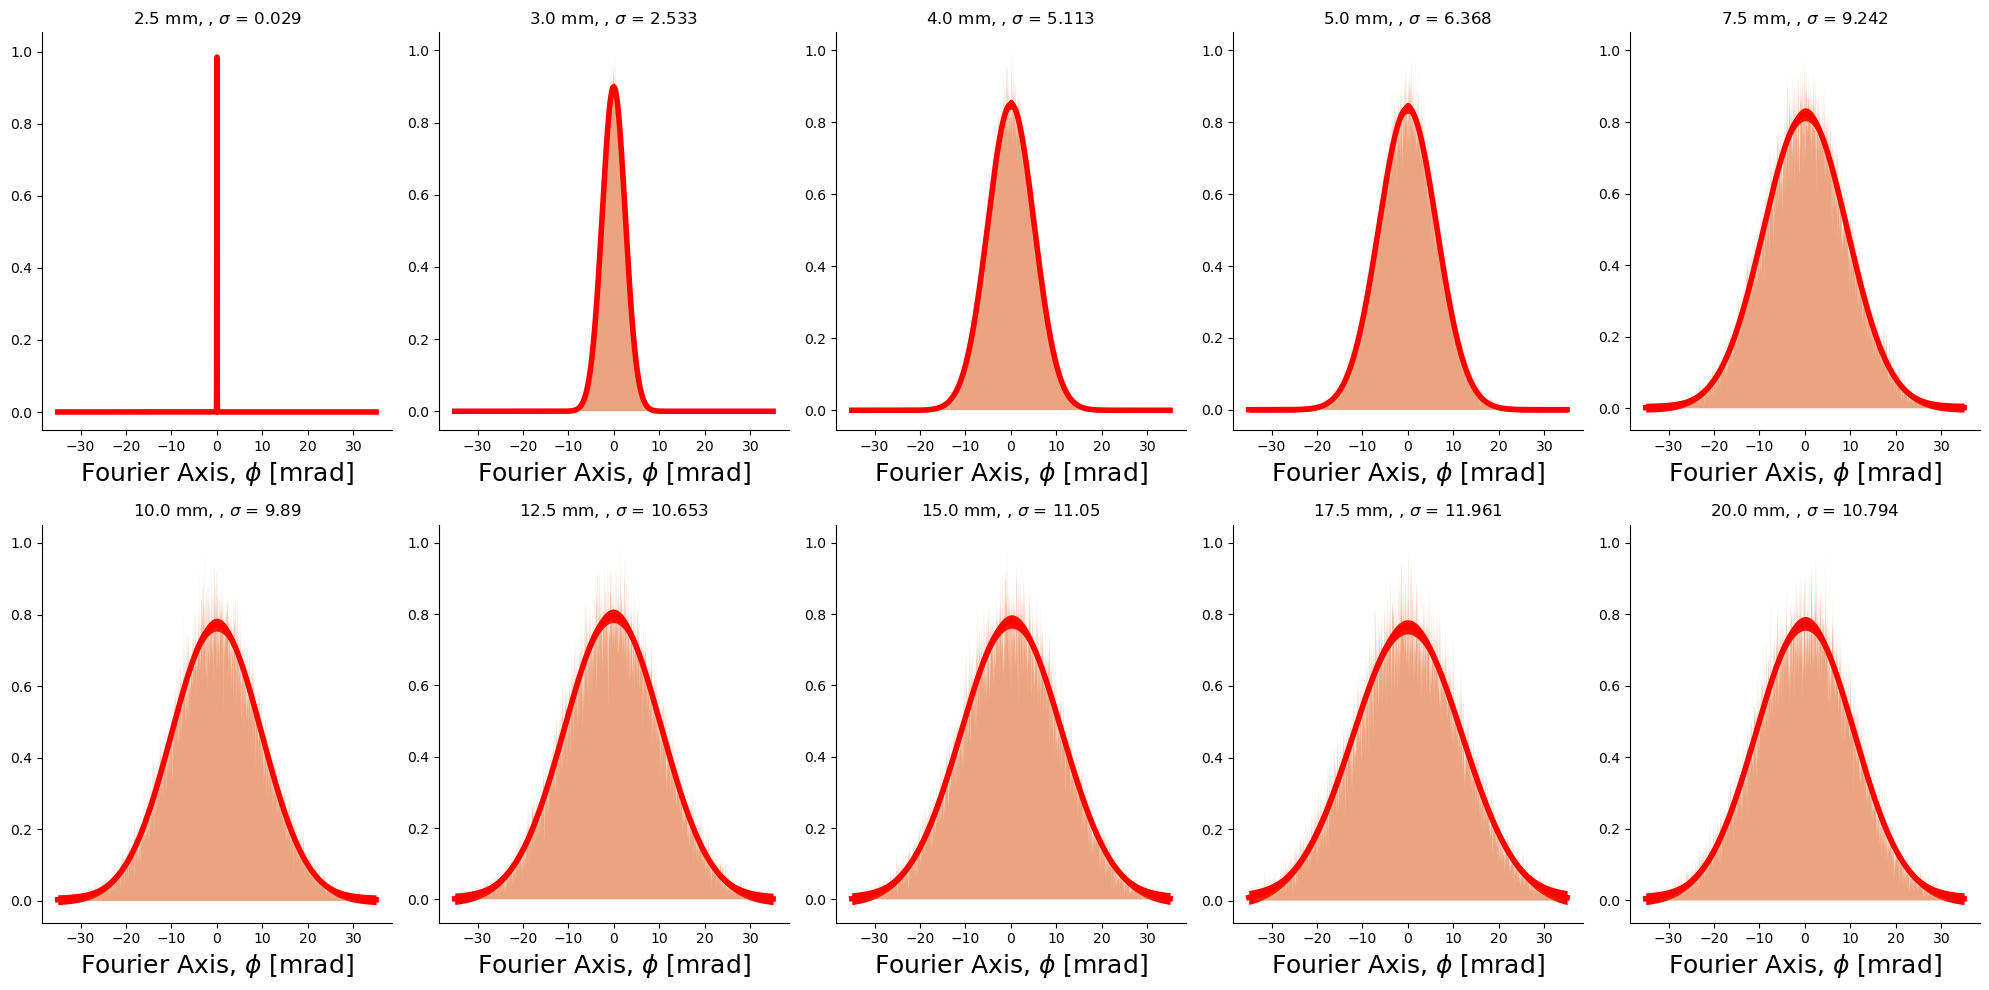

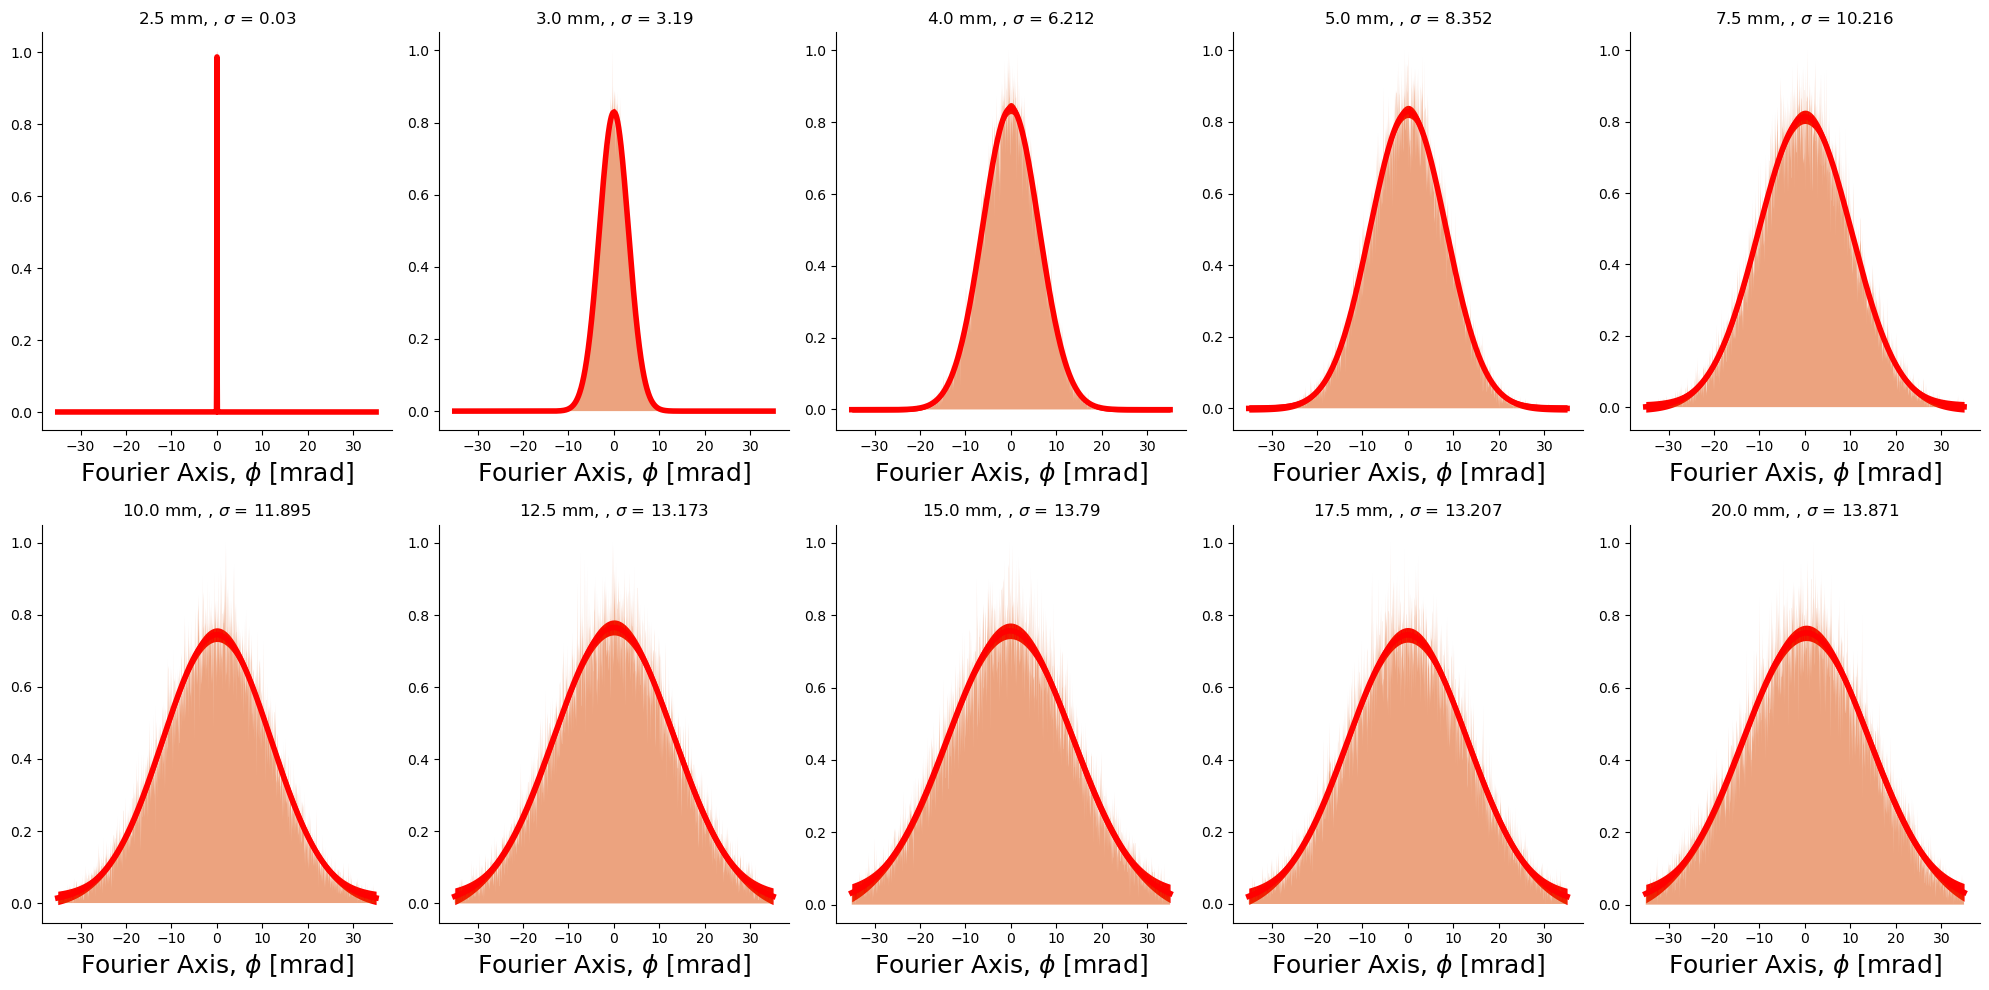

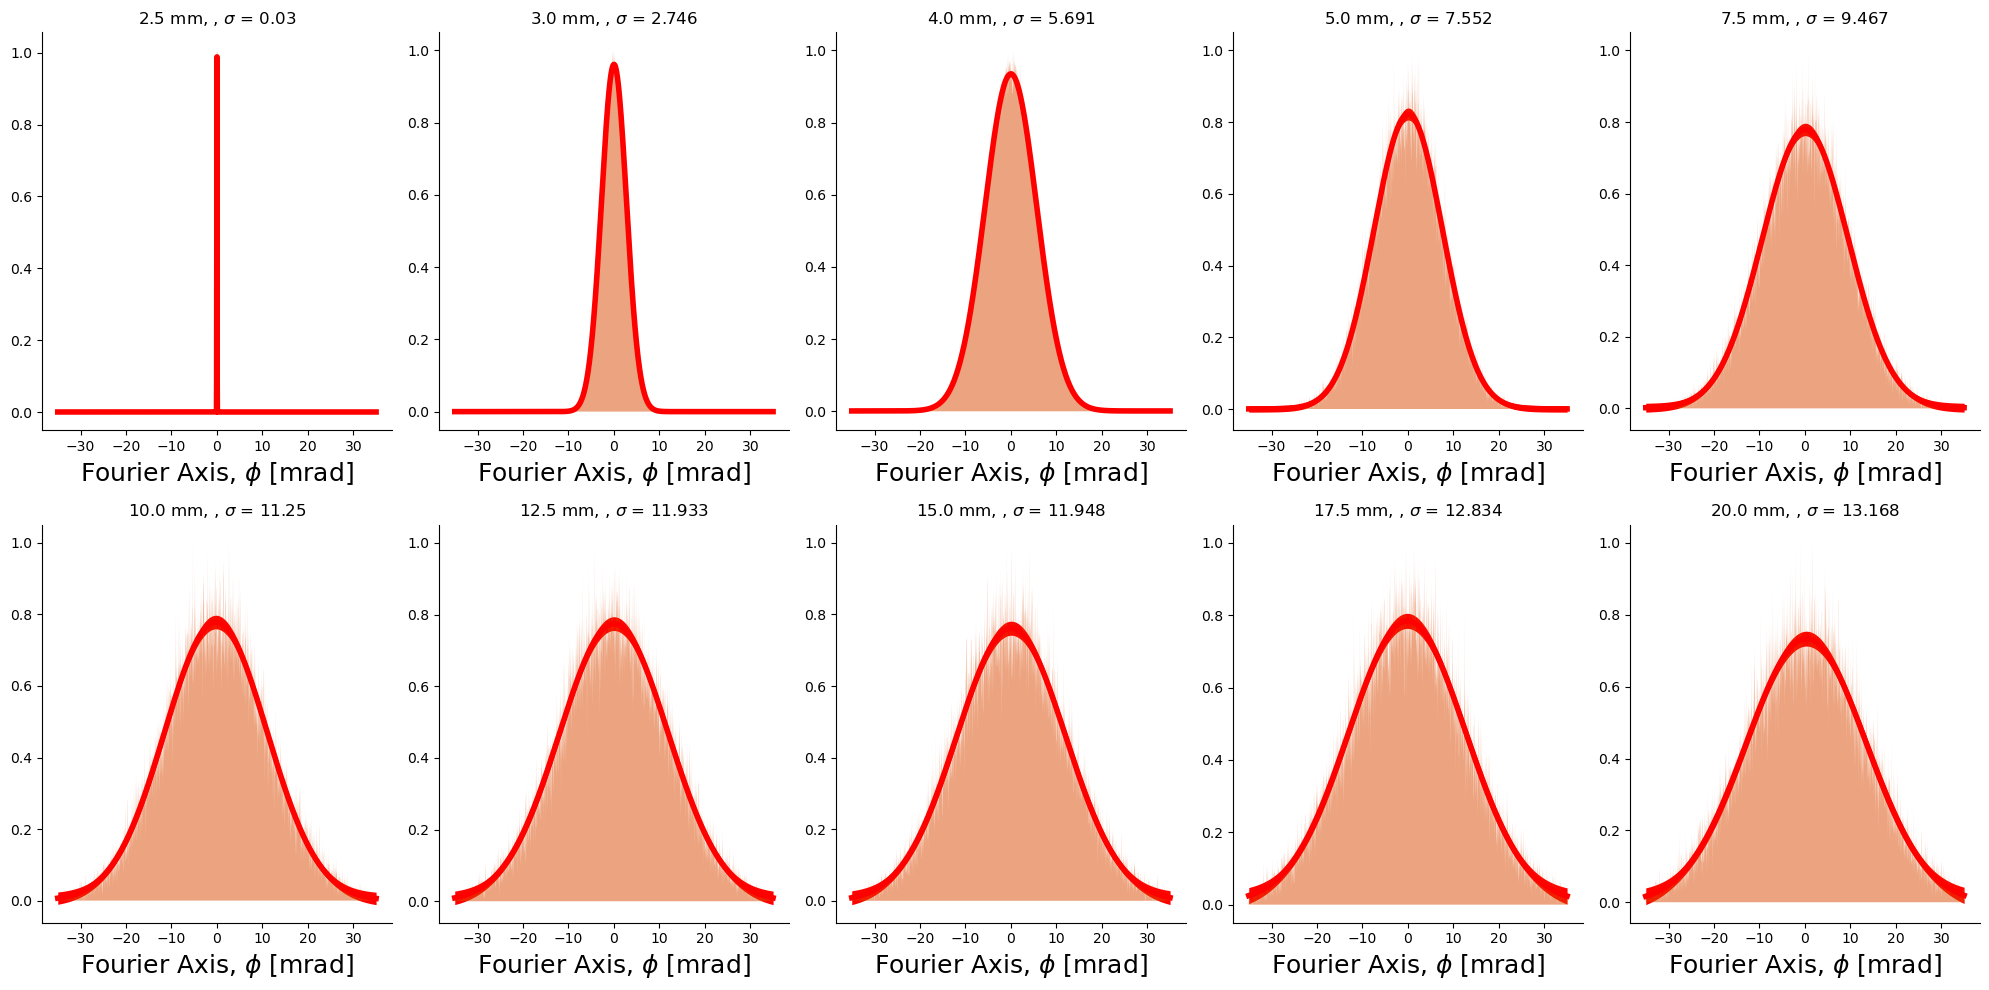

In [5]:
fig_35, sigma_35 = plot_grams(r_35)
fig_15, sigma_15 = plot_grams(r_15)
fig_25, sigma_25 = plot_grams(r_25)
print(sigma_35)

### Plot relationship between $\sigma_\phi$ and propagation distance $L_z$

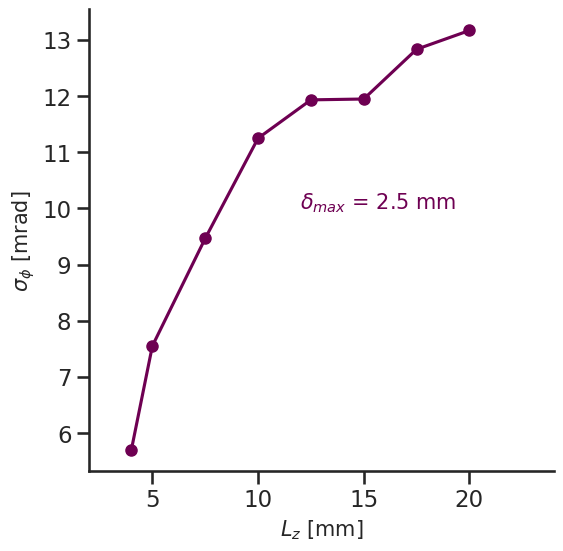

In [24]:
import seaborn as sns
from matplotlib import patches

def find_lz(sigma, epsilon = 1):
    ne = 1e25
    sigma = np.array(sigma)
    L_z = extents
    lwl = 1053e-9
    c = 3e8
    omega = 2*np.pi*(c/lwl)
    nc = 3.142e-4 * omega**2
    sigma *= 1e-3
    return ((ne**2)/(4*nc**2*sigma**2))*L_z*1e-3

l_35 = np.array(sigma_35)
l_15 = np.array(sigma_15)
l_25 = np.array(sigma_25)

sns.set(style="ticks", context="talk")
# plt.style.use("white")

lengths = extents
fig, ax = plt.subplots(figsize = (6,6))
# ax.plot(lengths[2:], l_15[2:], '-o', markersize = 8, color = c2, label = '1.5')
ax.plot(lengths[2:], l_25[2:], '-o', markersize = 8, color = c3, label = '2.5')
# ax.plot(lengths[2:], l_35[2:], '-o', markersize = 8, color = c4, label = '3.5')

# plt.hlines([1.5, 2.5, 3.5], 0, 20, zorder = 1, ls= ':', color = [c2,c3,c4], lw = 2.5, alpha = 0.8)
# plt.plot(np.log)
# plt.grid()
ax.set_ylabel(r'$\sigma_{\phi}$ [mrad]', fontsize = 15)
ax.set_xlabel(r'$L_z$ [mm]', fontsize = 15)
ax.spines[['right', 'top']].set_visible(False)

# ax.set_ylim(0, 5)
ax.set_xlim(2, 24)
# plt.plot(lengths, stds[1:], 'x')
# ax.tick_params(axis = 'both', which = 'major', labelsize = 15, width = 1, size = 5)
# ax.set_xticks([2, 4, 6, 8,10,12,14, 16,18,20])
# ax.annotate('$\delta_{max}$ = 3.5 mm', (21, 4.2), fontsize = 15, color = c4)
# ax.annotate('$\delta_{max}$ = 2.5 mm', (12, 10
                                        # ), fontsize = 15, color = c3)
# ax.annotate('$\delta_{max}$ = 1.5 mm', (21, 2.5), fontsize = 15, color = c2)
# for axis in ['top', 'bottom']:
#     ax.spines[axis].set_linewidth(1.5)
# con = patches.ConnectionPatch((2, 0.1), (2, 2.5), coordsA = 'data', coordsB = 'data', arrowstyle = "<->", shrinkA = 5, shrinkB = 5, mutation_scale = 10, lw = 2, color = 'white', zorder = 5)
# ax.add_artist(con)
# ax.annotate(r'Imposed Scale Range', (1.9, 0.75), rotation = 90, fontsize = 12, weight = 'bold')
plt.savefig('length_scale.png', dpi = 600)
plt.show()